In [1]:
'''
This is part of a project that we developed last year for Aprendizagem Computacional 1.
In this notebook we try a diferent aproach by using a Knn model.
We use the Naive version as well as a Weighted version (the one we found that performs the best for this dataset).
This aproach is not good. The accuracy is lower compared to NN and it takes a lot of time to process.
'''

'\nThis is part of a project that we developed last year for Aprendizagem Computacional 1.\nIn this notebook we try a diferent aproach by using a Knn model.\nWe use the Naive version as well as a Weighted version (the one we found that performs the best for this dataset).\nThis aproach is not good. The accuracy is lower compared to NN and it takes a lot of time to process.\n'

In [2]:
## Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import scipy.stats as sstats

In [3]:
## Distance metric

def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

#Weighting based on attributes inportance
def weightedEuclidean(point, data):
    weighted_point = point * importances
    weighted_data = data * importances
    return np.sqrt(np.sum((weighted_point - weighted_data)**2, axis=1))

In [4]:
## Naive knn

class knnNaive:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric   
        
    def most_common(self, lst):
        return max(set(lst), key=lst.count)
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train    
    
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])       
        return list(map(self.most_common, neighbors))    
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy, y_pred

In [5]:
## knn Weighted (1/dist)

class knnWeighted:
    def __init__(self, k=5, dist_metric=euclidean, normalized=False):
        self.k = k
        self.dist_metric = dist_metric
        self.normalized = normalized
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train    
        
    def find_res(self, data):
        result = {}
        for dist, cls in data:
            if cls not in result:
                result[cls] = {'weighted_dist': 0.0, 'num_elems': 0}
            weidist=1.0/(dist+0.000001)
            if weidist>1000: wwidist=1000
            result[cls]['weighted_dist'] += weidist
            result[cls]['num_elems'] += 1
        
        #Normalize the values to the avg
        if (self.normalized == True):
            total_num_elems = sum([stats['num_elems'] for stats in result.values()])
            num_classes = len(result)
            avg_num_elems = total_num_elems / num_classes

            for cls, stats in result.items():
                mult=avg_num_elems/stats['num_elems']
                stats['weighted_dist']=stats['weighted_dist']*mult
        
        res = None
        max_weighted_dist = -float('inf')
        for cls, stats in result.items():
            if stats['weighted_dist'] > max_weighted_dist:
                res = cls
                max_weighted_dist = stats['weighted_dist']
        return res
    
    def predict(self, X_test):
        res = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            kn = sorted(zip(distances, self.y_train))[:self.k]
            res.append(self.find_res(kn))
        return res   
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy, y_pred

In [6]:
## Reading data

data = pd.read_csv("D:/DATASET LIDC-IDRI/processeddata/features.csv")
data = data.dropna()
data=data.drop(['diagnostics_Mask-original_CenterOfMass','diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Versions_PyRadiomics','diagnostics_Versions_Numpy','diagnostics_Versions_SimpleITK','diagnostics_Versions_PyWavelet','diagnostics_Versions_Python','diagnostics_Configuration_Settings','diagnostics_Configuration_EnabledImageTypes','diagnostics_Image-original_Hash','diagnostics_Image-original_Dimensionality','diagnostics_Image-original_Spacing','diagnostics_Image-original_Size','diagnostics_Image-original_Mean','diagnostics_Image-original_Minimum','diagnostics_Image-original_Maximum','diagnostics_Mask-original_Hash','diagnostics_Mask-original_Spacing','diagnostics_Mask-original_Size','diagnostics_Mask-original_BoundingBox','diagnostics_Mask-original_VolumeNum','Sid','Unnamed: 0'],axis=1)

# Erasing entries with mal==3
i = data[data['Malignancy'] == 3].index
data = data.drop(i)
data = data.reset_index(drop=True)

In [7]:
## Splitting patients into groups

all_patients = data['Pid'].unique() #732

# Spliting patients into train, test and val groups
train_patients, test_patients = train_test_split(all_patients, test_size=0.3, random_state=42)

# Creating the train, test and val datasets
train_data = data[data['Pid'].isin(train_patients)]
test_data = data[data['Pid'].isin(test_patients)]

# Creating the train, test and val sets
X_train = train_data.drop(['Pid','Malignancy'], axis=1)
X_test = test_data.drop(['Pid','Malignancy'], axis=1)
y_train = train_data['Malignancy']
y_test = test_data['Malignancy']

# Mapping malignancy levels to binary labels
y_train = y_train.map({1: 0, 2: 0, 4: 1, 5: 1})
y_test = y_test.map({1: 0, 2: 0, 4: 1, 5: 1})

# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [8]:
## Get important attributes
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

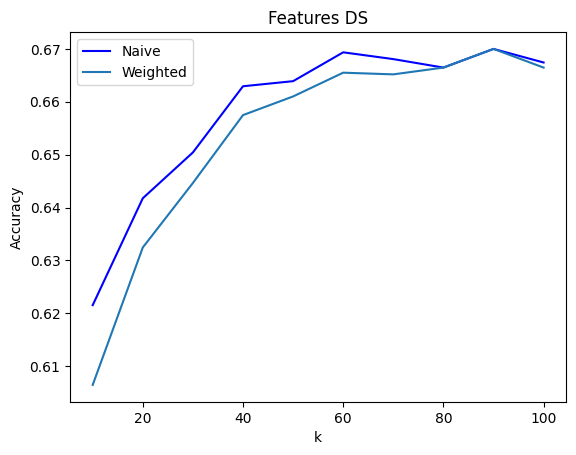

knnN=0.658178, knnW=0.653560


In [9]:
## Test the models

# Store accuracies
accuracies_naive = []
accuracies_wei = []

# Test knn models across varying ks
ks = range(10,101,10)
for k in ks:
    
    #Naive knn
    knnN = knnNaive(k=k)
    knnN.fit(X_train, y_train)
    accuracy, y_pred = knnN.evaluate(X_test, y_test)
    accuracies_naive.append(accuracy)
    
    #knn Weighted (1/dist)
    knnW = knnWeighted(k=k)
    knnW.fit(X_train, y_train)
    accuracy, y_pred = knnW.evaluate(X_test, y_test)
    accuracies_wei.append(accuracy)

# Plot the results
fig, ax = plt.subplots()
ax.plot(ks, accuracies_naive, color="blue", label="Naive")
ax.plot(ks, accuracies_wei, label="Weighted")

ax.set(xlabel="k",ylabel="Accuracy",title="Features DS")
ax.legend()
plt.show()
    
# Print the avg accuracies
avg_naive = sum(accuracies_naive) / len(accuracies_naive)
avg_wei = sum(accuracies_wei) / len(accuracies_wei)
    
print(f"knnN={avg_naive:.6f}, knnW={avg_wei:.6f}")